StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 18, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 11264


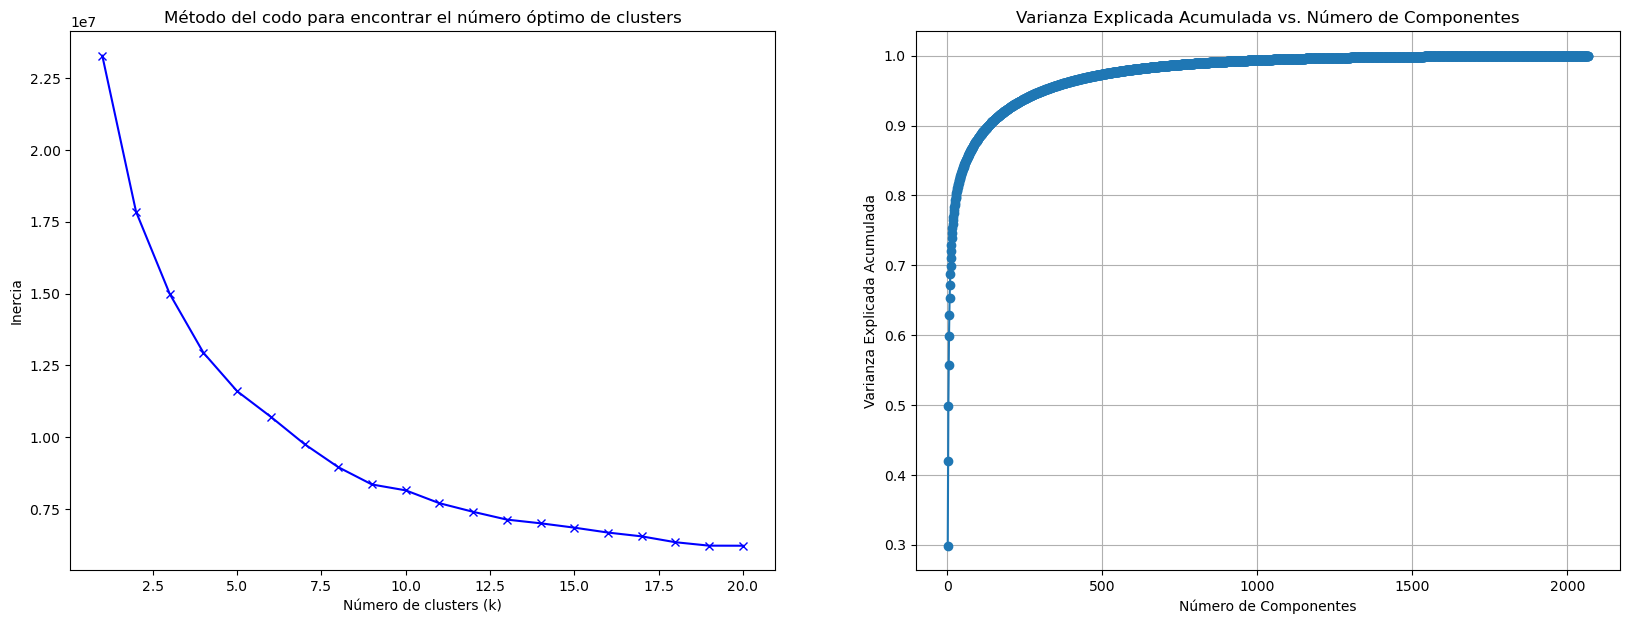

In [2]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Conectar al Blob Storage
connection_string = "***********************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "********"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings concatenados
blob_name_embeddings = "articles_embeddings_concatenated_roberta.json"
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=blob_name_embeddings)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(filtered_embeddings_array)

# Ajustar PCA y calcular la varianza explicada
pca = PCA().fit(normalized_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Aplicar K-means con diferentes valores de n_clusters para el método del codo
inertia = []
K = range(1, 21)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_embeddings)  # Asegúrate de usar los embeddings normalizados aquí
    inertia.append(kmeans.inertia_)

# Crear una figura con dos gráficos uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Graficar el método del codo
ax1.plot(K, inertia, 'bx-')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del codo para encontrar el número óptimo de clusters')

# Graficar la varianza explicada acumulada
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Explicada Acumulada')
ax2.set_title('Varianza Explicada Acumulada vs. Número de Componentes')
ax2.grid(True)

plt.show()


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 32, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 11264
Cluster labels: [0 1 2 3]
Number of clusters: 4
Silhouette Score: 0.7987395524978638


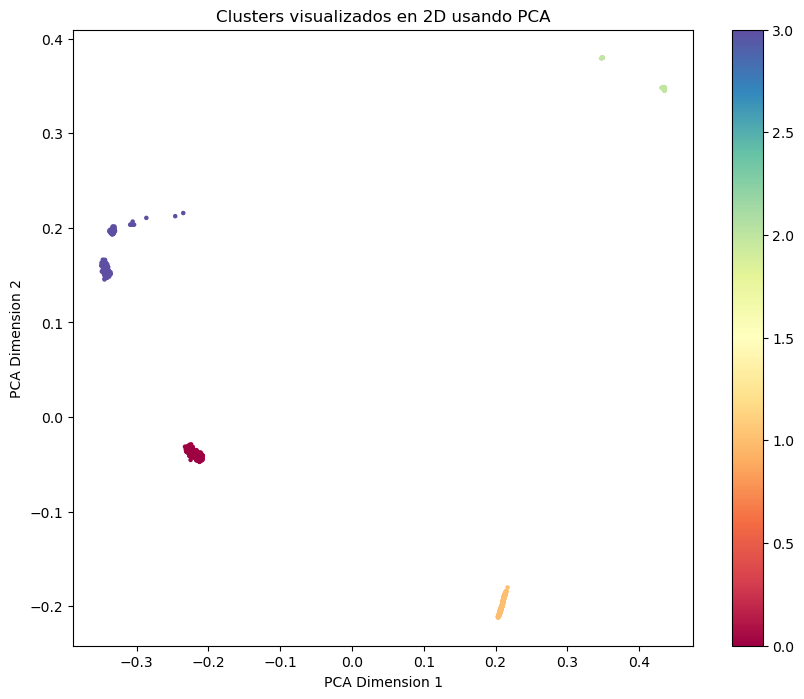

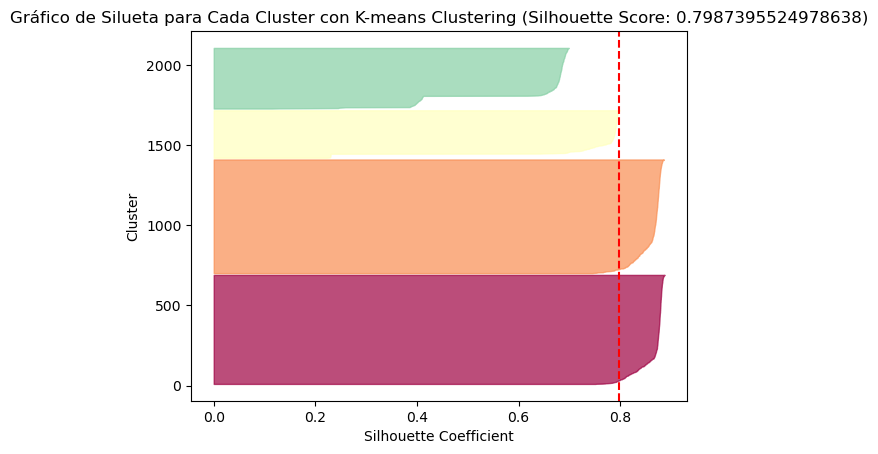

Clusters guardados en articles_embeddings_concatenated_padding_kmeans_roberta.json en el contenedor newsdata.


In [16]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

# K-MEANS roberta-large

# Conectar al Blob Storage
connection_string = "********************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "*********"
input_blob_name = "articles_embeddings_concatenated_roberta.json"
clustering_output_blob_name = "articles_embeddings_concatenated_padding_kmeans_roberta.json"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]
filtered_content_ids = [content_id for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
normalized_embeddings = filtered_embeddings_array / np.linalg.norm(filtered_embeddings_array, axis=1, keepdims=True)

# Reducir la dimensionalidad con PCA
n_components = 400  # Ajustado valor basado en análisis previo
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Realizar el clustering con K-means
n_clusters = 4  
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans_model.fit_predict(reduced_embeddings)

# Obtener las etiquetas de los clusters
labels = kmeans_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels))}")

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(reduced_embeddings, labels)
    sample_silhouette_values = silhouette_samples(reduced_embeddings, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D usando PCA para reducir a 2 componentes
pca_2d = PCA(n_components=2)
pca_2d_embeddings = pca_2d.fit_transform(normalized_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_2d_embeddings[:, 0], pca_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

# Graficar el índice de silueta para cada punto
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con K-means Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster.")

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster
clustered_texts = []
for content_id, text, label in zip(filtered_content_ids, filtered_texts, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id, "text": text})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("clusters.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
blob_client_clusters = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)
with open("clusters.json", "rb") as data:
    blob_client_clusters.upload_blob(data, overwrite=True)

print(f"Clusters guardados en {clustering_output_blob_name} en el contenedor {container_name}.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 31, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 11264
Cluster labels: [-1  0  1  2  3  4  5]
Number of clusters: 7
Silhouette Score: 0.8542304635047913


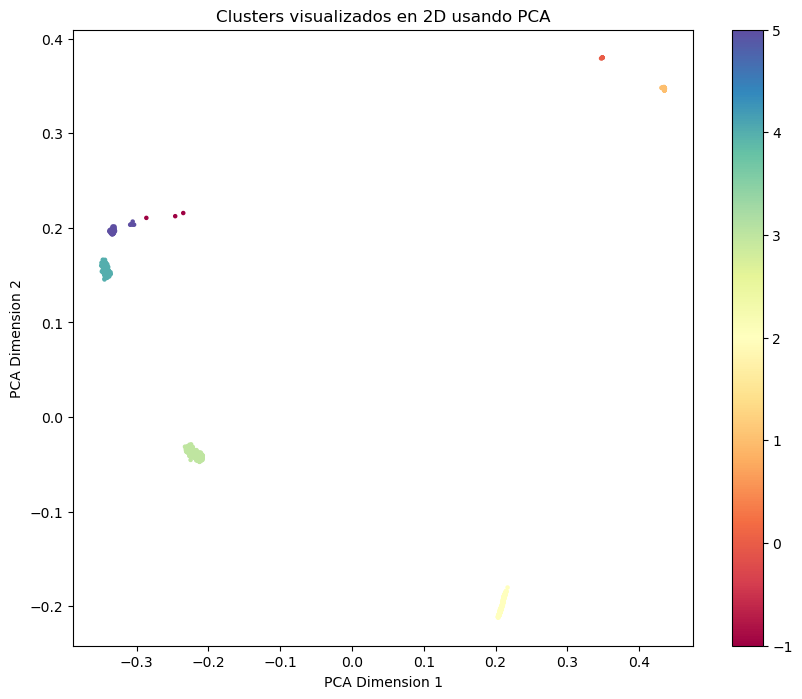

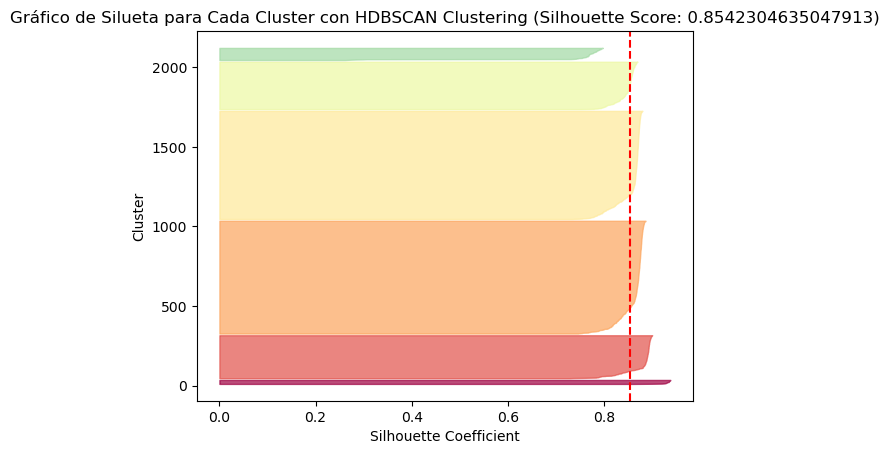

Clusters guardados en articles_embeddings_concatenated_padding_hdbscan_roberta.json en el contenedor newsdata.


In [15]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
import hdbscan
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

#HDBSCAN roberta-large

# Conectar al Blob Storage
connection_string = "****************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "****************"
input_blob_name = "articles_embeddings_concatenated_roberta.json"
clustering_output_blob_name = "articles_embeddings_concatenated_padding_hdbscan_roberta.json"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]
filtered_content_ids = [content_id for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
normalized_embeddings = filtered_embeddings_array / np.linalg.norm(filtered_embeddings_array, axis=1, keepdims=True)

# Reducir la dimensionalidad con PCA
n_components = 400  # Ajustado valor basado en análisis previo
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Realizar el clustering con HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5)
clusters = hdbscan_model.fit_predict(reduced_embeddings)

# Obtener las etiquetas de los clusters
labels = hdbscan_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels))}")

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(reduced_embeddings, labels)
    sample_silhouette_values = silhouette_samples(reduced_embeddings, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D usando PCA para reducir a 2 componentes
pca_2d = PCA(n_components=2)
pca_2d_embeddings = pca_2d.fit_transform(normalized_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_2d_embeddings[:, 0], pca_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(labels)) - 1):  # Excluye el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster
clustered_texts = []
for content_id, text, label in zip(filtered_content_ids, filtered_texts, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id, "text": text})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("clusters.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
blob_client_clusters = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)
with open("clusters.json", "rb") as data:
    blob_client_clusters.upload_blob(data, overwrite=True)

print(f"Clusters guardados en {clustering_output_blob_name} en el contenedor {container_name}.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 29, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 11264
Cluster labels: [-1  0  1  2  3  4  5  6  7]
Number of clusters: 9
Silhouette Score: 0.8107283115386963


/nfs4/pyenv-dae9a546-5be0-44a5-afbc-d15abd3e424e/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/nfs4/pyenv-dae9a546-5be0-44a5-afbc-d15abd3e424e/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/trusted-service-user/cluster-env/env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


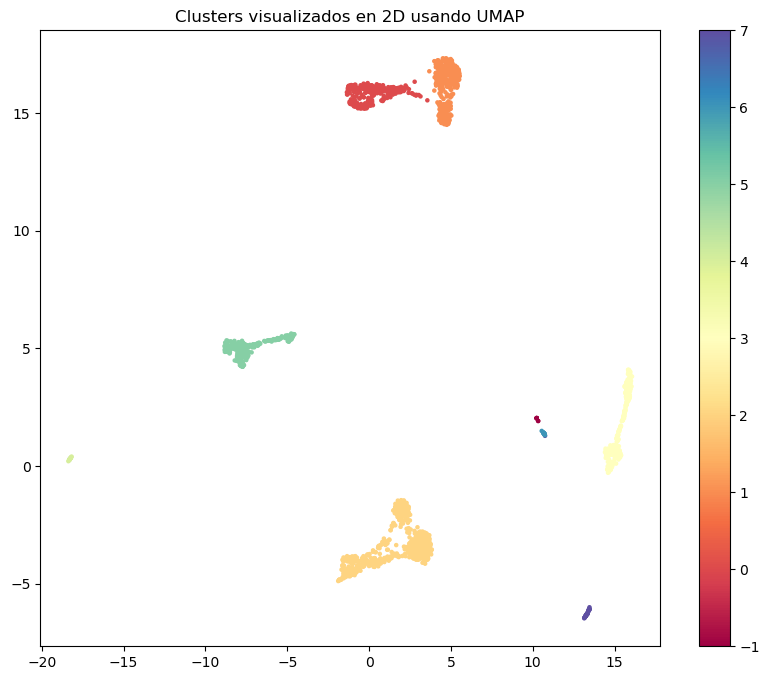

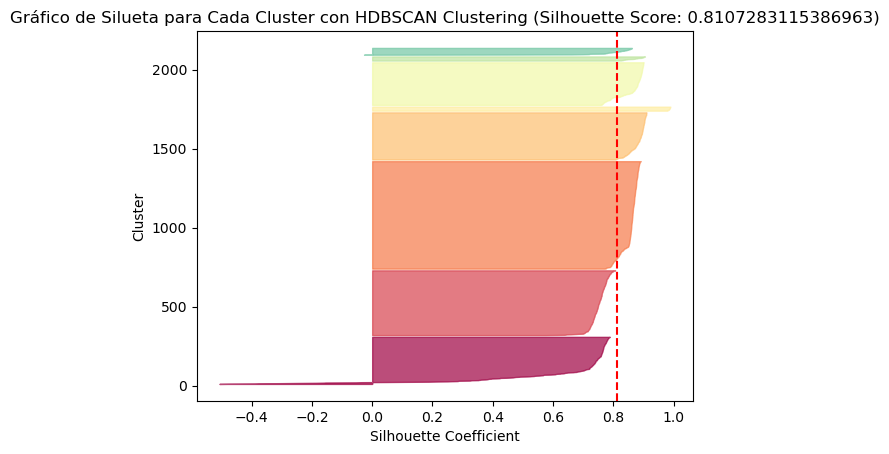

Clusters guardados en articles_embeddings_concatenated_padding_umap_hdbscan_roberta.json en el contenedor newsdata.


In [13]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
import hdbscan
from umap import UMAP
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

# UMAP + HDBSCAN  roberta-large

# Conectar al Blob Storage
connection_string = "****************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "****************"
input_blob_name = "articles_embeddings_concatenated_roberta.json"
clustering_output_blob_name = "articles_embeddings_concatenated_padding_umap_hdbscan_roberta.json"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]
filtered_content_ids = [content_id for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Reducir la dimensionalidad con UMAP
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(filtered_embeddings_array)

# Realizar el clustering con HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5)
clusters = hdbscan_model.fit_predict(umap_embeddings)

# Obtener las etiquetas de los clusters
labels = hdbscan_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels))}")

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(umap_embeddings, labels)
    sample_silhouette_values = silhouette_samples(umap_embeddings, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D
umap_2d = UMAP(n_components=2, random_state=42)
umap_2d_embeddings = umap_2d.fit_transform(filtered_embeddings_array)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_2d_embeddings[:, 0], umap_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando UMAP')
plt.show()

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(labels)) - 1):  # Excluye el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster
clustered_texts = []
for content_id, text, label in zip(filtered_content_ids, filtered_texts, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id, "text": text})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("clusters.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
blob_client_clusters = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)
with open("clusters.json", "rb") as data:
    blob_client_clusters.upload_blob(data, overwrite=True)

print(f"Clusters guardados en {clustering_output_blob_name} en el contenedor {container_name}.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 33, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 8192


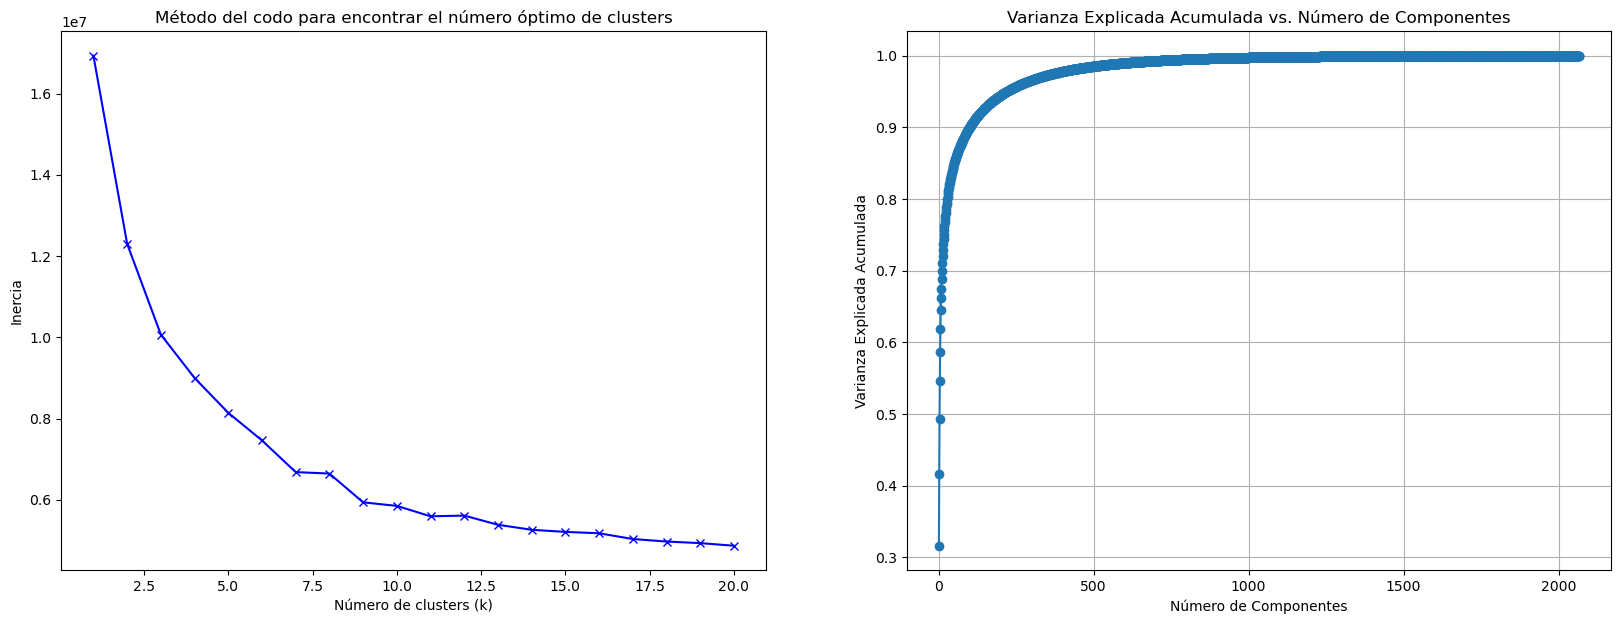

In [17]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Conectar al Blob Storage
connection_string = "****************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "****************"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings concatenados
blob_name_embeddings = "articles_embeddings_concatenated_roberta_CA.json"
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=blob_name_embeddings)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(filtered_embeddings_array)

# Ajustar PCA y calcular la varianza explicada
pca = PCA().fit(normalized_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Aplicar K-means con diferentes valores de n_clusters para el método del codo
inertia = []
K = range(1, 21)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_embeddings)  # Asegúrate de usar los embeddings normalizados aquí
    inertia.append(kmeans.inertia_)

# Crear una figura con dos gráficos uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Graficar el método del codo
ax1.plot(K, inertia, 'bx-')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del codo para encontrar el número óptimo de clusters')

# Graficar la varianza explicada acumulada
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Explicada Acumulada')
ax2.set_title('Varianza Explicada Acumulada vs. Número de Componentes')
ax2.grid(True)

plt.show()


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 34, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 8192
Cluster labels: [0 1 2 3]
Number of clusters: 4
Silhouette Score: 0.506106972694397


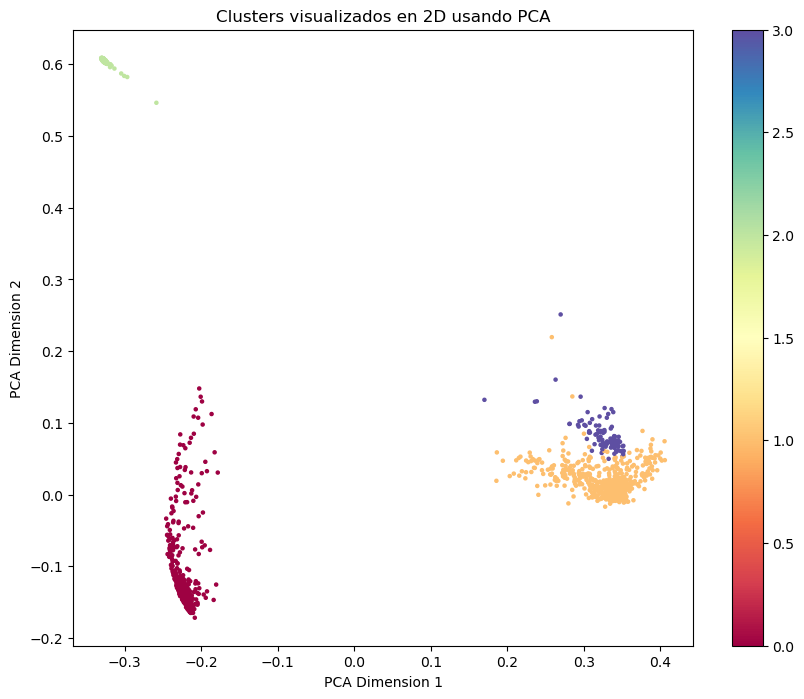

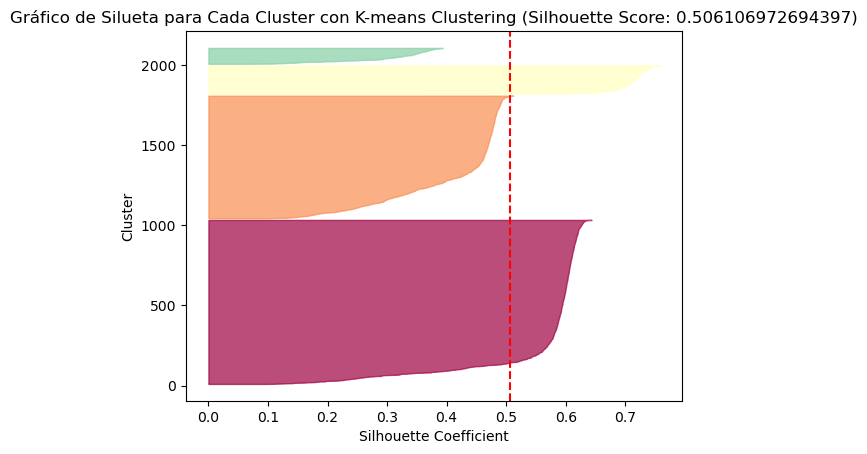

Clusters guardados en articles_embeddings_concatenated_padding_kmeans_roberta_CA.json en el contenedor newsdata.


In [18]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

#KMEANS
# Conectar al Blob Storage
connection_string = "****************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "****************"
input_blob_name = "articles_embeddings_concatenated_roberta_CA.json"
clustering_output_blob_name = "articles_embeddings_concatenated_padding_kmeans_roberta_CA.json"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]
filtered_content_ids = [content_id for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
normalized_embeddings = filtered_embeddings_array / np.linalg.norm(filtered_embeddings_array, axis=1, keepdims=True)

# Reducir la dimensionalidad con PCA
n_components = 400  # Ajustado valor basado en análisis previo
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Realizar el clustering con K-means
n_clusters = 4  
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans_model.fit_predict(reduced_embeddings)

# Obtener las etiquetas de los clusters
labels = kmeans_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels))}")

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(reduced_embeddings, labels)
    sample_silhouette_values = silhouette_samples(reduced_embeddings, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D usando PCA para reducir a 2 componentes
pca_2d = PCA(n_components=2)
pca_2d_embeddings = pca_2d.fit_transform(normalized_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_2d_embeddings[:, 0], pca_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

# Graficar el índice de silueta para cada punto
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con K-means Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster.")

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster
clustered_texts = []
for content_id, text, label in zip(filtered_content_ids, filtered_texts, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id, "text": text})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("clusters.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
blob_client_clusters = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)
with open("clusters.json", "rb") as data:
    blob_client_clusters.upload_blob(data, overwrite=True)

print(f"Clusters guardados en {clustering_output_blob_name} en el contenedor {container_name}.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 35, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 8192
Cluster labels: [-1  0  1  2  3]
Number of clusters: 5
Silhouette Score: 0.5017523169517517


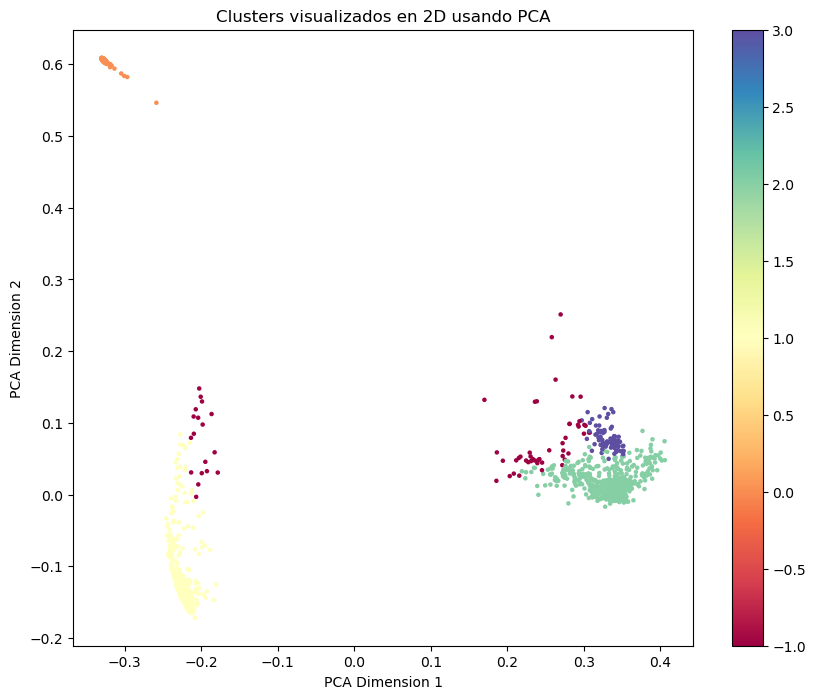

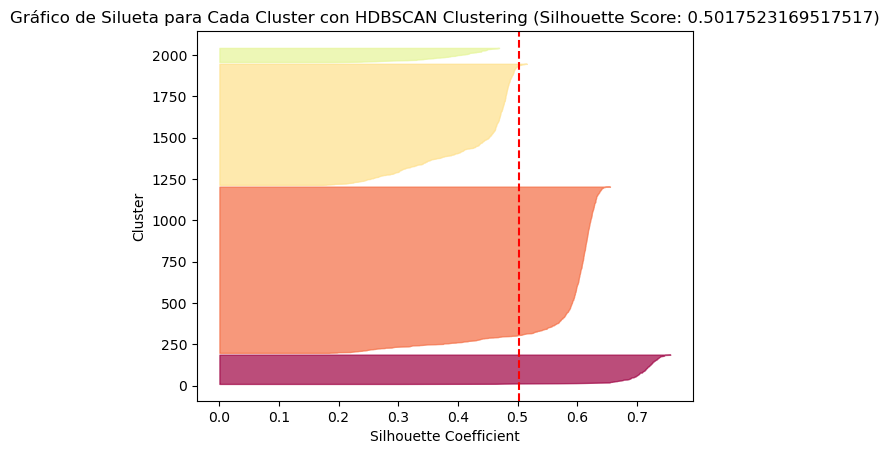

Clusters guardados en articles_embeddings_concatenated_padding_hdbscan_roberta_CA.json en el contenedor newsdata.


In [19]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
import hdbscan
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

#HDBSCAN  roberta-large-ca-v2

# Conectar al Blob Storage
connection_string = "****************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "****************"
input_blob_name = "articles_embeddings_concatenated_roberta_CA.json"
clustering_output_blob_name = "articles_embeddings_concatenated_padding_hdbscan_roberta_CA.json"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]
filtered_content_ids = [content_id for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
normalized_embeddings = filtered_embeddings_array / np.linalg.norm(filtered_embeddings_array, axis=1, keepdims=True)

# Reducir la dimensionalidad con PCA
n_components = 400  # Ajustado valor basado en análisis previo
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Realizar el clustering con HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5)
clusters = hdbscan_model.fit_predict(reduced_embeddings)

# Obtener las etiquetas de los clusters
labels = hdbscan_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels))}")

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(reduced_embeddings, labels)
    sample_silhouette_values = silhouette_samples(reduced_embeddings, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D usando PCA para reducir a 2 componentes
pca_2d = PCA(n_components=2)
pca_2d_embeddings = pca_2d.fit_transform(normalized_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_2d_embeddings[:, 0], pca_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(labels)) - 1):  # Excluye el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster
clustered_texts = []
for content_id, text, label in zip(filtered_content_ids, filtered_texts, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id, "text": text})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("clusters.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
blob_client_clusters = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)
with open("clusters.json", "rb") as data:
    blob_client_clusters.upload_blob(data, overwrite=True)

print(f"Clusters guardados en {clustering_output_blob_name} en el contenedor {container_name}.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 42, 36, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 8192
Cluster labels: [0 1 2 3]
Number of clusters: 4
Silhouette Score: 0.8674402236938477


/nfs4/pyenv-dae9a546-5be0-44a5-afbc-d15abd3e424e/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/nfs4/pyenv-dae9a546-5be0-44a5-afbc-d15abd3e424e/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


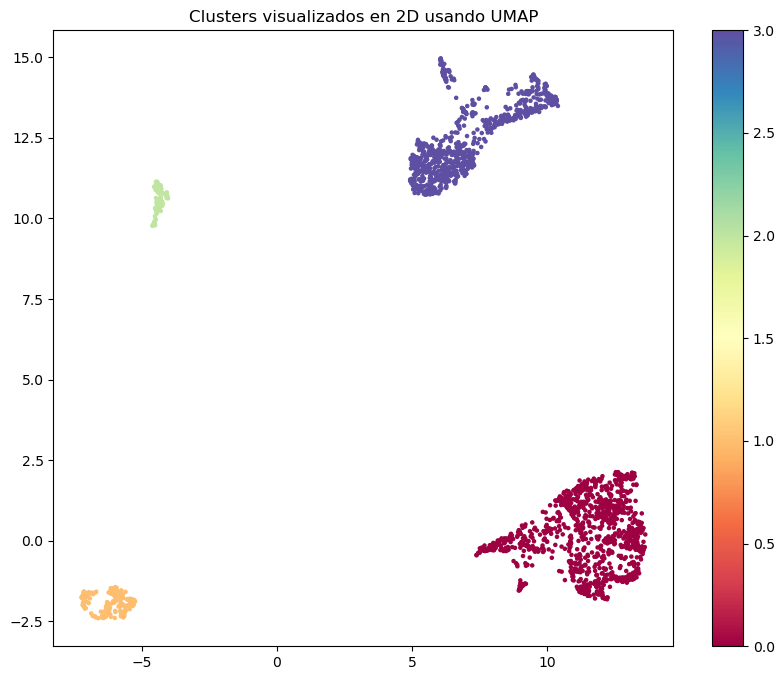

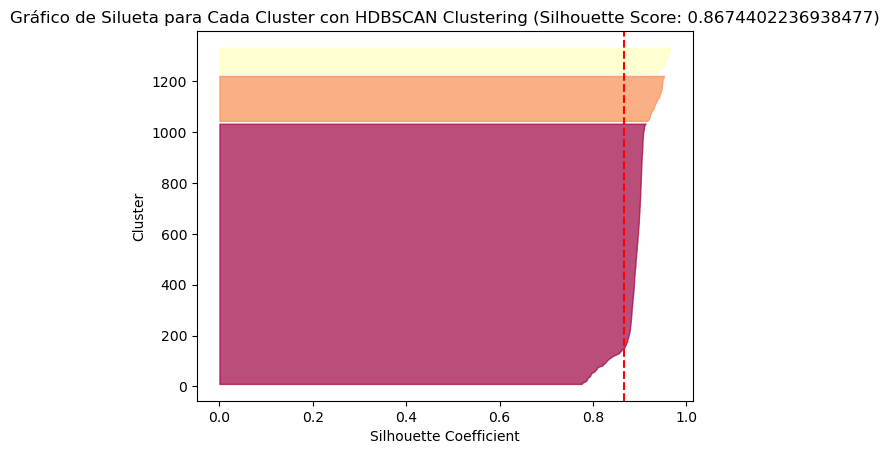

Clusters guardados en articles_embeddings_concatenated_padding_umap_hdbscan_roberta_CA.json en el contenedor newsdata.


In [20]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
import hdbscan
from umap import UMAP
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

# UMAP + HDBSCAN   roberta-large-ca-v2

# Conectar al Blob Storage
connection_string = "****************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "****************"
input_blob_name = "articles_embeddings_concatenated_roberta_CA.json"
clustering_output_blob_name = "articles_embeddings_concatenated_padding_umap_hdbscan_roberta_CA.json"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]
filtered_content_ids = [content_id for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Reducir la dimensionalidad con UMAP
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(filtered_embeddings_array)

# Realizar el clustering con HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5)
clusters = hdbscan_model.fit_predict(umap_embeddings)

# Obtener las etiquetas de los clusters
labels = hdbscan_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels))}")

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(umap_embeddings, labels)
    sample_silhouette_values = silhouette_samples(umap_embeddings, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D
umap_2d = UMAP(n_components=2, random_state=42)
umap_2d_embeddings = umap_2d.fit_transform(filtered_embeddings_array)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_2d_embeddings[:, 0], umap_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando UMAP')
plt.show()

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(labels)) - 1):  # Excluye el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster
clustered_texts = []
for content_id, text, label in zip(filtered_content_ids, filtered_texts, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id, "text": text})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("clusters.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
blob_client_clusters = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)
with open("clusters.json", "rb") as data:
    blob_client_clusters.upload_blob(data, overwrite=True)

print(f"Clusters guardados en {clustering_output_blob_name} en el contenedor {container_name}.")
